In [2]:
from __future__ import absolute_import, division, print_function
import uproot
import numpy as np
import matplotlib.pyplot as plt

# energyflow imports
import energyflow as ef
from energyflow.archs import *
from energyflow.utils import data_split, remap_pids, to_categorical

from sklearn.metrics import roc_auc_score, roc_curve

In [3]:
h2gg_dir = '/home/sambt/pythia-samples/optimal-classifiers/test-samples/H2gg-ee/'
h2qq_dir = '/home/sambt/pythia-samples/optimal-classifiers/test-samples/H2qqbar-ee/'
kern = -1
CFs = [0.0001,1/3,2/3,1,4/3,5/3,2,7/3,8/3,3]
#CFs = [0.0001,1/3,2/3]
CAs = [3.0]

In [11]:
roc_curves = {}
aucs = {}
mult_rocs = {}
mult_aucs = {}
mass_rocs = {}
mass_aucs = {}

#vars for comparison roc curves
masses = []
mults = []
Y_compare = []
for CF in CFs:
    for CA in CAs:
        fname_gg = 'kernel{0}/H2gg-ee-CF-{1:.2f}-CA-{2:.2f}.root'.format(kern,CF,CA)
        fname_qq = 'kernel{0}/H2qqbar-ee-CF-{1:.2f}-CA-{2:.2f}.root'.format(kern,CF,CA)

        f_gg = uproot.open(h2gg_dir+fname_gg)['EventTree']
        f_qq = uproot.open(h2qq_dir+fname_qq)['EventTree']

        gjet_pt = f_gg.array("plead_constit_pt")
        gjet_eta = f_gg.array("plead_constit_eta")
        gjet_phi = f_gg.array("plead_constit_phi")

        qjet_pt = f_qq.array("plead_constit_pt")
        qjet_eta = f_qq.array("plead_constit_eta")
        qjet_phi = f_qq.array("plead_constit_phi")

        #remove events where there is no leading quark or gluon jet for some reason
        gjet_pt = gjet_pt[np.count_nonzero(gjet_pt,axis=1) > 0]
        gjet_eta = gjet_eta[np.count_nonzero(gjet_eta,axis=1) > 0]
        gjet_phi = gjet_phi[np.count_nonzero(gjet_phi,axis=1) > 0]

        qjet_pt = qjet_pt[np.count_nonzero(qjet_pt,axis=1) > 0]
        qjet_eta = qjet_eta[np.count_nonzero(qjet_eta,axis=1) > 0]
        qjet_phi = qjet_phi[np.count_nonzero(qjet_phi,axis=1) > 0]

        #get size of constituent pt/eta/phi arrays; set to 100 in MC generation (more than needed) and padded with zeros
        pad_size = np.size(qjet_pt,axis=1)
        nev_gg = np.size(gjet_pt,axis=0)
        nev_qq = np.size(qjet_pt,axis=0)

        quarks = np.array([[[qjet_pt[i,j],qjet_eta[i,j],qjet_phi[i,j]] for j in range(pad_size)] for i in range(nev_qq)])
        gluons = np.array([[[gjet_pt[i,j],gjet_eta[i,j],gjet_phi[i,j]] for j in range(pad_size)] for i in range(nev_gg)])

        #make vectors with truth labels, combine q & g samples, shuffle
        quark_labs = np.ones(np.size(quarks,axis=0))
        glu_labs = np.zeros(np.size(gluons,axis=0))

        X = np.concatenate((quarks,gluons))
        y = np.concatenate((quark_labs,glu_labs))

        shuf = np.arange(np.size(X,axis=0))
        np.random.shuffle(shuf)

        X = X[shuf]
        y = y[shuf]

        #network parameters
        train, test, val = 7500, 1000, 1500
        Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
        num_epoch = 5
        batch_size = 500

        #convert quark/gluon labels to categorical
        Y = to_categorical(y,num_classes=2)

        # preprocess by centering jets and normalizing pts
        for x in X:
            mask = x[:,0] > 0
            yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
            x[mask,1:3] -= yphi_avg
            x[mask,0] /= x[:,0].sum()

        print('Finished preprocessing')

        # do train/val/test split 
        (X_train, X_val, X_test,
         Y_train, Y_val, Y_test) = data_split(X, Y, train=train, val=val, test=test)

        print('Done train/val/test split')

        print('Model summary:')

        # build architecture
        pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

        # train model
        pfn.fit(X_train, Y_train,
                  epochs=num_epoch,
                  batch_size=batch_size,
                  validation_data=(X_val, Y_val),
                  verbose=1)

        # get predictions on test data
        preds = pfn.predict(X_test, batch_size=1000)
        
        #pfn.model.save("saved_models/kern{0}/PFN_CF{1:.2f}_CA{2:.2f}".format(kern,CF,CA))

        pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

        # get area under the ROC curve
        auc = roc_auc_score(Y_test[:,1], preds[:,1])
        print()
        print('PFN AUC:', auc)
        print()

        roc_curves[CF] = (pfn_fp, pfn_tp, threshs)
        aucs[CF] = auc
        
        masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
        mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
        mass_rocs[CF] = roc_curve(Y[:,1], -masses)
        mass_aucs[CF] = roc_auc_score(Y[:,1],-masses)
        mult_rocs[CF] = roc_curve(Y[:,1], -mults)
        mult_aucs[CF] = roc_auc_score(Y[:,1],-mults)

        if (CF == 4/3 and CA == 3):
            # get multiplicity and mass for comparison
            masses_default = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
            mults_default = np.asarray([np.count_nonzero(x[:,0]) for x in X])
            Y_compare = Y

Finished preprocessing
Done train/val/test split
Model summary:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 3)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    400         input[0][0]                      
__________________________________________________________________________________________________
activation_141 (Activation)     (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_141[0][0]             
_____________________________________________

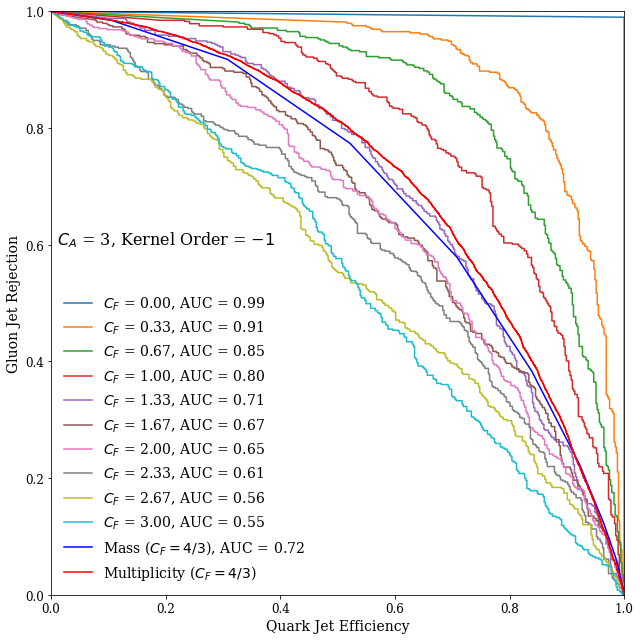

In [13]:
#make roc curves for mass & multiplicity (in default CF/CA case) as comparison
mass_fp, mass_tp, threshs = mult_rocs[4/3]
mult_fp, mult_tp, threshs = mass_rocs[4/3]

#plotting ROC curves

# some nicer plot settings 
plt.rcParams['figure.figsize'] = (9,9)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

# plot the ROC curves
for CF in CFs:
    pfn_fp, pfn_tp, threshs = roc_curves[CF]
    plt.plot(pfn_tp, 1-pfn_fp, '-', label=r'$C_F$ = {0:.2f}, AUC = {1:.2f}'.format(CF,aucs[CF]))


plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label=r'Mass ($C_F = 4/3$), AUC = {0:.2f}'.format(mass_aucs[4/3]))
plt.plot(mult_tp, 1-mult_fp, '-', color='red', label=r'Multiplicity ($C_F = 4/3$)'.format(mult_aucs[4/3]))

# axes labels
plt.xlabel('Quark Jet Efficiency',fontsize=14)
plt.ylabel('Gluon Jet Rejection',fontsize=14)

# axes limits
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# make legend and show plot
plt.legend(loc='lower left', frameon=False,fontsize=14)
plt.text(0.01,0.6,r"$C_A$ = 3, Kernel Order = $-1$",fontsize=16)
plt.show()
#plt.savefig("PFN_ROCs_CFscan_kerneln1.pdf")

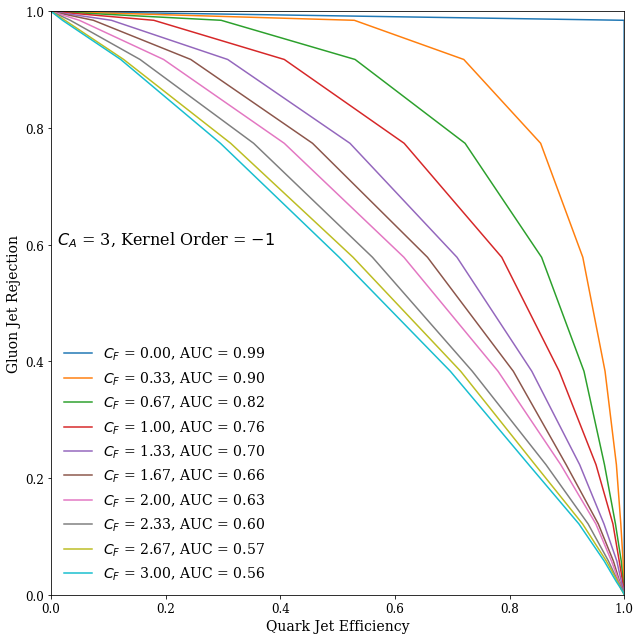

In [15]:
#plotting multiplicity ROC curves

# some nicer plot settings 
plt.rcParams['figure.figsize'] = (9,9)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

# plot the ROC curves
for CF in CFs:
    pfn_fp, pfn_tp, threshs = mult_rocs[CF]
    plt.plot(pfn_tp, 1-pfn_fp, '-', label=r'$C_F$ = {0:.2f}, AUC = {1:.2f}'.format(CF,mult_aucs[CF]))

# axes labels
plt.xlabel('Quark Jet Efficiency',fontsize=14)
plt.ylabel('Gluon Jet Rejection',fontsize=14)

# axes limits
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# make legend and show plot
plt.legend(loc='lower left', frameon=False,fontsize=14)
plt.text(0.01,0.6,r"$C_A$ = 3, Kernel Order = $-1$",fontsize=16)
plt.show()
#plt.savefig("PFN_ROCs_CFscan_kerneln1.pdf")

In [10]:
#doing kernel = 1, CF = 4/3 for quick comparison
fname_gg = 'kernel{0}/H2gg-ee-100k_CF_{1:.1f}_CA_{2:.1f}/total.root'.format(1,4/3,3)
fname_qq = 'kernel{0}/H2qqbar-ee-100k_CF_{1:.1f}_CA_{2:.1f}/total.root'.format(1,4/3,3)

f_gg = uproot.open(h2gg_dir+fname_gg)['EventTree']
f_qq = uproot.open(h2qq_dir+fname_qq)['EventTree']

gjet_pt = f_gg.array("plead_constit_pt")
gjet_eta = f_gg.array("plead_constit_eta")
gjet_phi = f_gg.array("plead_constit_phi")

qjet_pt = f_qq.array("plead_constit_pt")
qjet_eta = f_qq.array("plead_constit_eta")
qjet_phi = f_qq.array("plead_constit_phi")

#remove events where there is no leading quark or gluon jet for some reason
gjet_pt = gjet_pt[np.count_nonzero(gjet_pt,axis=1) > 0]
gjet_eta = gjet_eta[np.count_nonzero(gjet_eta,axis=1) > 0]
gjet_phi = gjet_phi[np.count_nonzero(gjet_phi,axis=1) > 0]

qjet_pt = qjet_pt[np.count_nonzero(qjet_pt,axis=1) > 0]
qjet_eta = qjet_eta[np.count_nonzero(qjet_eta,axis=1) > 0]
qjet_phi = qjet_phi[np.count_nonzero(qjet_phi,axis=1) > 0]

#get size of constituent pt/eta/phi arrays; set to 100 in MC generation (more than needed) and padded with zeros
pad_size = np.size(qjet_pt,axis=1)
nev_gg = np.size(gjet_pt,axis=0)
nev_qq = np.size(qjet_pt,axis=0)

quarks = np.array([[[qjet_pt[i,j],qjet_eta[i,j],qjet_phi[i,j]] for j in range(pad_size)] for i in range(nev_qq)])
gluons = np.array([[[gjet_pt[i,j],gjet_eta[i,j],gjet_phi[i,j]] for j in range(pad_size)] for i in range(nev_gg)])

#make vectors with truth labels, combine q & g samples, shuffle
quark_labs = np.ones(np.size(quarks,axis=0))
glu_labs = np.zeros(np.size(gluons,axis=0))

X = np.concatenate((quarks,gluons))
y = np.concatenate((quark_labs,glu_labs))

shuf = np.arange(np.size(X,axis=0))
np.random.shuffle(shuf)

X = X[shuf]
y = y[shuf]

#network parameters
train, test, val = 75000, 10000, 15000
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
num_epoch = 5
batch_size = 500

#convert quark/gluon labels to categorical
Y = to_categorical(y,num_classes=2)

# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

print('Finished preprocessing')

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, train=train, val=val, test=test)

print('Done train/val/test split')

print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

# train model
pfn.fit(X_train, Y_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(X_val, Y_val),
          verbose=1)

# get predictions on test data
preds = pfn.predict(X_test, batch_size=1000)

pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

pfn.model.save("saved_models/kern{0}/PFN_CF{1:.2f}_CA{2:.2f}".format(1,4/3,3))

# get area under the ROC curve
auc = roc_auc_score(Y_test[:,1], preds[:,1])
print()
print('PFN AUC:', auc)
print()

mults_extra = np.asarray([np.count_nonzero(x[:,0]) for x in X])
Y_extra = Y

Finished preprocessing
Done train/val/test split
Model summary:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 3)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    400         input[0][0]                      
__________________________________________________________________________________________________
activation_92 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_92[0][0]              
_____________________________________________

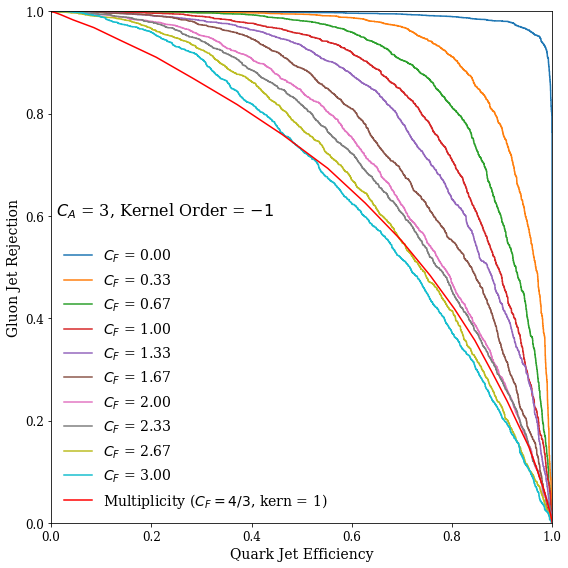

In [13]:
#make roc curves for mass & multiplicity (in default CF/CA case) as comparison
mult_extra_fp, mult_extra_tp, threshs_extra = roc_curve(Y_extra[:,1], -mults_extra)

#plotting ROC curves

# some nicer plot settings 
plt.rcParams['figure.figsize'] = (8,8)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

# plot the ROC curves
for CF in CFs:
    pfn_fp, pfn_tp, threshs = roc_curves[CF]
    plt.plot(pfn_tp, 1-pfn_fp, '-', label=r'$C_F$ = {0:.2f}'.format(CF))

plt.plot(mult_extra_tp, 1-mult_extra_fp, '-', color='red', label=r'Multiplicity ($C_F = 4/3$, kern = 1)')

# axes labels
plt.xlabel('Quark Jet Efficiency',fontsize=14)
plt.ylabel('Gluon Jet Rejection',fontsize=14)

# axes limits
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# make legend and show plot
plt.legend(loc='lower left', frameon=False,fontsize=14)
plt.text(0.01,0.6,r"$C_A$ = 3, Kernel Order = $-1$",fontsize=16)
plt.savefig("PFN_ROCs_CFscan_kerneln1_compare_kern1mult.png")
plt.show()